In [1]:
# Cargar librerías necesarias
library(survey)
library(dplyr)
library(parallel)
library(ggplot2)
library(reshape2)
library(gridExtra)
library(tidyr)
source('PC.R')
source('RegDI2.R')

Warning message:
"package 'survey' was built under R version 4.3.3"
Loading required package: grid

Loading required package: Matrix

Loading required package: survival

Warning message:
"package 'survival' was built under R version 4.3.2"

Attaching package: 'survey'


The following object is masked from 'package:graphics':

    dotchart



Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine



Attaching package: 'tidyr'


The following object is masked from 'package:reshape2':

    smiths


The following objects are masked from 'package:Matrix':

    expand, pack, unpack




## Simulación 1: 
En esta simulación se va a elaborar la simulación mostrada en las sección 6.

In [1]:
# Función para generar la población
generar_poblacion <- function(N, size_a, n_B1, n_B2, seed = NULL) {
  if (!is.null(seed)) {
    set.seed(seed)  # Asegurar reproducibilidad si se proporciona una semilla
  }
  
  # Generación de la población
  x_i <- rnorm(N, mean = 2, sd = 1)
  eta_i <- rnorm(N, mean = 0, sd = sqrt(0.51))
  y_i <- 3 + 0.7 * (x_i - 2) + eta_i
  
  # Generar la versión contaminada de y_i (tilde_y_i)
  tilde_y_i <- 2 + 0.9 * (y_i - 3) + rnorm(N, mean = 0, sd = 0.5)
  
  # Generar variables auxiliares e_i y las variables indicadoras e1_i y e2_i
  rho <- 0.5
  v_i <- rnorm(N, mean = 0, sd = 1)
  e_i <- rho * x_i + sqrt(1 - rho^2) * v_i  # Variable correlacionada
  e1_i <- ifelse(e_i <= 1, 1, 0)            # Variable indicadora e1_i
  e2_i <- ifelse(e_i > 1, 1, 0)             # Variable indicadora e2_i
  
  # Generar las variables auxiliares x1_i y x2_i
  x1_i <- ifelse(x_i <= 2, 1, 0) 
  x2_i <- ifelse(x_i > 2, 1, 0)
  
  # Crear data.frame de la población
  poblacion <- data.frame(
    id = 1:N,
    x_i = x_i,
    y_i = y_i,
    tilde_y_i = tilde_y_i,
    e_i = e_i,
    e1_i = e1_i,
    e2_i = e2_i,
    x1_i = x1_i,
    x2_i = x2_i
  )
  
  # Seleccionar muestra probabilística A (S_A) de tamaño 1000
  indices_A <- sample(1:N, size = size_a, replace = FALSE)
  poblacion$muestra_A <- 0
  poblacion$muestra_A[indices_A] <- 1
  
  # Seleccionar muestra no probabilística B (S_B) mediante estratificación
  stratum1 <- which(poblacion$x_i <= 2)
  stratum2 <- which(poblacion$x_i > 2)
  indices_B1 <- sample(stratum1, size = n_B1, replace = FALSE)
  indices_B2 <- sample(stratum2, size = n_B2, replace = FALSE)
  indices_B <- c(indices_B1, indices_B2)
  poblacion$muestra_B <- 0
  poblacion$muestra_B[indices_B] <- 1
  
  return(poblacion)
}

# Generar una sola población con los parámetros especificados
N <- 100000  # Tamaño de la población
size_a <- 1000  # Tamaño de la muestra probabilística A
n_B1 <- 30000  # Tamaño del estrato 1 de la muestra no probabilística B
n_B2 <- 20000  # Tamaño del estrato 2 de la muestra no probabilística B

# Generar la población
poblacion_generada <- generar_poblacion(N, size_a, n_B1, n_B2, seed = 1234)

# Visualizar un resumen de la población generada
summary(poblacion_generada)


       id              x_i              y_i           tilde_y_i     
 Min.   :     1   Min.   :-2.509   Min.   :-1.980   Min.   :-2.271  
 1st Qu.: 25001   1st Qu.: 1.329   1st Qu.: 2.329   1st Qu.: 1.306  
 Median : 50001   Median : 2.004   Median : 3.004   Median : 2.009  
 Mean   : 50001   Mean   : 2.003   Mean   : 3.004   Mean   : 2.005  
 3rd Qu.: 75000   3rd Qu.: 2.674   3rd Qu.: 3.672   3rd Qu.: 2.698  
 Max.   :100000   Max.   : 5.906   Max.   : 7.361   Max.   : 6.546  
      e_i               e1_i             e2_i             x1_i       
 Min.   :-3.2001   Min.   :0.0000   Min.   :0.0000   Min.   :0.0000  
 1st Qu.: 0.3245   1st Qu.:0.0000   1st Qu.:0.0000   1st Qu.:0.0000  
 Median : 1.0002   Median :0.0000   Median :1.0000   Median :0.0000  
 Mean   : 0.9997   Mean   :0.4999   Mean   :0.5001   Mean   :0.4983  
 3rd Qu.: 1.6725   3rd Qu.:1.0000   3rd Qu.:1.0000   3rd Qu.:1.0000  
 Max.   : 5.2789   Max.   :1.0000   Max.   :1.0000   Max.   :1.0000  
      x2_i          muestra

### Simulación

In [19]:
# Número de simulaciones Monte Carlo
n_sim <- 1000

# Parámetros de la simulación
N <- 100000     # Tamaño de la población
size_a <- 1000  # Tamaño de la muestra probabilística A
n_B1 <- 30000    # Tamaño de la primera estratificación de la muestra B
n_B2 <- 20000    # Tamaño de la segunda estratificación de la muestra B
Y_true <- 3     # Valor verdadero de la media poblacional

# Inicializar listas para acumular las estimaciones de cada simulación
estimates_list <- list(
  Mean_S_A = numeric(n_sim),
  Mean_S_B = numeric(n_sim),
  RegDI = numeric(n_sim),
  RegDI_X1 = numeric(n_sim),
  RegDI_e1 = numeric(n_sim),
  PC_X1 = numeric(n_sim),
  PC_e1 = numeric(n_sim),
  Mean_S_B_II = numeric(n_sim),
  RegDI_II = numeric(n_sim),
  RegDI_X1_II = numeric(n_sim),
  RegDI_e1_II = numeric(n_sim),
  PC_X1_II = numeric(n_sim),
  PC_e1_II = numeric(n_sim)
)

# Realizar la simulación Monte Carlo
for (sim in 1:n_sim) {
  
  # Generar la población
  poblacion <- generar_poblacion(N, size_a, n_B1, n_B2, seed = sim)
  
  # Calcular los estimadores para el Escenario I
  
  # Media de la muestra A
  design_A <- svydesign(ids = ~1, data = subset(poblacion, muestra_A == 1), weights = ~1)
  mean_S_A <- coef(svymean(~y_i, design_A))
  estimates_list$Mean_S_A[sim] <- mean_S_A
  
  # Media de la muestra B
  design_B <- svydesign(ids = ~1, data = subset(poblacion, muestra_B == 1), weights = ~1)
  mean_S_B <- coef(svymean(~y_i, design_B))
  estimates_list$Mean_S_B[sim] <- mean_S_B

      # Media de la muestra B
  design_B_II <- svydesign(ids = ~1, data = subset(poblacion, muestra_B == 1), weights = ~1)
  mean_S_B_II <- coef(svymean(~tilde_y_i, design_B_II))
  estimates_list$Mean_S_B_II[sim] <- mean_S_B_II
  
  # RegDI sin variables auxiliares
  result_RegDI_I <- RegDI2(
    data = poblacion,
    y_A_col = "y_i",
    y_B_col = "y_i",
    ind_var_A = "muestra_A",
    ind_var_B = "muestra_B",
    aux_vars = NULL,
    N_total = N
  )
  estimates_list$RegDI[sim] <- result_RegDI_I$mean_RegDI
  
  # RegDI con x1_i
  result_RegDI_I_x1 <- RegDI2(
    data = poblacion,
    y_A_col = "y_i",
    y_B_col = "y_i",
    ind_var_A = "muestra_A",
    ind_var_B = "muestra_B",
    aux_vars = c("x1_i"),
    N_total = N
  )
  estimates_list$RegDI_X1[sim] <- result_RegDI_I_x1$mean_RegDI
  
  # RegDI con e1_i
  result_RegDI_I_e1 <- RegDI2(
    data = poblacion,
    y_A_col = "y_i",
    y_B_col = "y_i",
    ind_var_A = "muestra_A",
    ind_var_B = "muestra_B",
    aux_vars = c("e1_i"),
    N_total = N
  )
  estimates_list$RegDI_e1[sim] <- result_RegDI_I_e1$mean_RegDI
  
  # PC_Estimator con x1_i, x2_i
  result_PC_New_I_X1_X2 <- PC_Estimator(
    data = poblacion,
    y_A_col = "y_i",
    y_B_col = "y_i",
    ind_var_A = "muestra_A",
    ind_var_B = "muestra_B",
    aux_vars = c("x1_i", "x2_i"),
    N_total = N,
    weights_A = NULL,
    weights_B = NULL,
    scenario = 1,
    outcome_model = NULL,
    model_type = "normal",
    eval_model_performance = FALSE
  )
  estimates_list$PC_X1[sim] <- result_PC_New_I_X1_X2$estimator
  
  # PC_Estimator con e1_i, e2_i
  result_PC_New_I_e1_e2 <- PC_Estimator(
    data = poblacion,
    y_A_col = "y_i",
    y_B_col = "y_i",
    ind_var_A = "muestra_A",
    ind_var_B = "muestra_B",
    aux_vars = c("e1_i", "e2_i"),
    N_total = N,
    weights_A = NULL,
    weights_B = NULL,
    scenario = 1,
    outcome_model = NULL,
    model_type = "normal",
    eval_model_performance = FALSE
  )
  estimates_list$PC_e1[sim] <- result_PC_New_I_e1_e2$estimator
  
  # Repetir el cálculo para el Escenario II
  
  # RegDI sin variables auxiliares (tilde_y_i en B)
  result_RegDI_II <- RegDI2(
    data = poblacion,
    y_A_col = "y_i",
    y_B_col = "tilde_y_i",
    ind_var_A = "muestra_A",
    ind_var_B = "muestra_B",
    aux_vars = NULL,
    N_total = N
  )
  estimates_list$RegDI_II[sim] <- result_RegDI_II$mean_RegDI
  
  # RegDI con x1_i (tilde_y_i en B)
  result_RegDI_II_x1 <- RegDI2(
    data = poblacion,
    y_A_col = "y_i",
    y_B_col = "tilde_y_i",
    ind_var_A = "muestra_A",
    ind_var_B = "muestra_B",
    aux_vars = c("x1_i"),
    N_total = N
  )
  estimates_list$RegDI_X1_II[sim] <- result_RegDI_II_x1$mean_RegDI
  
  # RegDI con e1_i (tilde_y_i en B)
  result_RegDI_II_e1 <- RegDI2(
    data = poblacion,
    y_A_col = "y_i",
    y_B_col = "tilde_y_i",
    ind_var_A = "muestra_A",
    ind_var_B = "muestra_B",
    aux_vars = c("e1_i"),
    N_total = N
  )
  estimates_list$RegDI_e1_II[sim] <- result_RegDI_II_e1$mean_RegDI
  
  # PC_Estimator con x1_i, x2_i (tilde_y_i en B)
  result_PC_New_II_X1_X2 <- PC_Estimator(
    data = poblacion,
    y_A_col = "y_i",
    y_B_col = "y_i",
    ind_var_A = "muestra_A",
    ind_var_B = "muestra_B",
    aux_vars = c("x1_i", "x2_i"),
    N_total = N,
    weights_A = NULL,
    weights_B = NULL,
    scenario = 2,
    outcome_model = "y_i ~ tilde_y_i",
    model_type = "normal",
    eval_model_performance = FALSE
  )
  estimates_list$PC_X1_II[sim] <- result_PC_New_II_X1_X2$estimator
  
  # PC_Estimator con e1_i, e2_i (tilde_y_i en B)
  result_PC_New_II_e1_e2 <- PC_Estimator(
    data = poblacion,
    y_A_col = "y_i",
    y_B_col = "y_i",
    ind_var_A = "muestra_A",
    ind_var_B = "muestra_B",
    aux_vars = c("e1_i", "e2_i"),
    N_total = N,
    weights_A = NULL,
    weights_B = NULL,
    scenario = 2,
    outcome_model = "y_i ~ tilde_y_i",
    model_type = "normal",
    eval_model_performance = FALSE
  )
  estimates_list$PC_e1_II[sim] <- result_PC_New_II_e1_e2$estimator
}

# Calcular el sesgo promedio
bias_avg <- sapply(estimates_list, function(estimates) mean(estimates - Y_true))

# Calcular el error estándar (desviación estándar de las estimaciones)
se_mc <- sapply(estimates_list, sd)

                   # Calcular el RMSE (Raíz del Error Cuadrático Medio)
rmse_calc <- function(bias, se) {
  sqrt(bias^2 + se^2)
}
                   
# Crear el dataframe final con los resultados de sesgo promedio y el error estándar
results_summary <- data.frame(
  Scenario = c(rep("I", 7), rep("II", 6)),  # 7 estimadores para el Escenario I, 5 para el Escenario II
  Estimator = c("Mean_S_A", "Mean_S_B", "RegDI", "RegDI_X1", "RegDI_e1", "PC_X1", "PC_e1",
                "Mean_S_B", "RegDI", "RegDI_X1", "RegDI_e1", "PC_X1", "PC_e1"),
  Bias = round(c(bias_avg["Mean_S_A"], bias_avg["Mean_S_B"], bias_avg["RegDI"], bias_avg["RegDI_X1"], 
                 bias_avg["RegDI_e1"], bias_avg["PC_X1"], bias_avg["PC_e1"],  bias_avg["Mean_S_B_II"],
                 bias_avg["RegDI_II"], bias_avg["RegDI_X1_II"], bias_avg["RegDI_e1_II"],
                 bias_avg["PC_X1_II"], bias_avg["PC_e1_II"]), 3),
  SE = round(c(se_mc["Mean_S_A"], se_mc["Mean_S_B"], se_mc["RegDI"], se_mc["RegDI_X1"],
               se_mc["RegDI_e1"], se_mc["PC_X1"], se_mc["PC_e1"],  se_mc["Mean_S_B_II"],
               se_mc["RegDI_II"], se_mc["RegDI_X1_II"], se_mc["RegDI_e1_II"],
               se_mc["PC_X1_II"], se_mc["PC_e1_II"]), 3)
)

# Añadir la columna del RMSE
results_summary$RMSE <- round(rmse_calc(results_summary$Bias, results_summary$SE), 3)

# Mostrar el resumen final con sesgos, error estándar y RMSE
print(results_summary)

            Scenario Estimator   Bias    SE  RMSE
Mean_S_A           I  Mean_S_A  0.000 0.030 0.030
Mean_S_B           I  Mean_S_B -0.112 0.004 0.112
RegDI              I     RegDI -0.001 0.022 0.022
RegDI_X1           I  RegDI_X1 -0.001 0.022 0.022
RegDI_e1           I  RegDI_e1 -0.001 0.022 0.022
PC_X1              I     PC_X1  0.000 0.004 0.004
PC_e1              I     PC_e1 -0.094 0.004 0.094
Mean_S_B_II       II  Mean_S_B -1.101 0.004 1.101
RegDI_II          II     RegDI  0.000 0.025 0.025
RegDI_X1_II       II  RegDI_X1  0.000 0.025 0.025
RegDI_e1_II       II  RegDI_e1  0.000 0.025 0.025
PC_X1_II          II     PC_X1  0.001 0.016 0.016
PC_e1_II          II     PC_e1 -0.070 0.016 0.072


## Simulación Muestra estratificada

**Propósito**: El objetivo de esta simulación es evaluar la flexibilidad de los métodos de estimación cuando no se dispone de totales poblacionales conocidos y, en su lugar, se deben calcular a partir de una muestra probabilística. En otras palabras, la simulación se centrará en cómo los estimadores pueden ajustarse adecuadamente basándose únicamente en la información proporcionada por una muestra probabilística, en lugar de asumir el conocimiento completo de la población.

1. **Generación de la población**: Se generará una población ficticia de tamaño $N = 1,000,000$ con variables auxiliares y de estudio. Las variables auxiliares generadas son:
   - $x_i$: variable continua que sigue una distribución normal $N(10, 1)$,
   - $z_i$: variable binaria que sigue una distribución de Bernoulli con $P = 0.5$,
   - $stratum$: variable de estratificación que clasifica la población en cuatro estratos, definidos por combinaciones de los valores de $x_i$ y $z_i$.

2. **Variable de estudio**: Se definirá la variable de estudio $y_i$ mediante la ecuación:
   $$
   y_i = 5 + 0.2 \cdot x_i + 3 \cdot z_i + \epsilon_i
   $$
   donde $\epsilon_i$ es un error aleatorio generado a partir de una distribución normal $N(0, 1)$.

3. **Variable contaminada $\tilde{y}_i$**: La variable $\tilde{y}_i$ es una versión contaminada de $y_i$, definida como:
   $$
   \tilde{y}_i = y_i + 3 (y_i - \bar{y}_i) + e_i
   $$
   donde $e_i$ es un error aleatorio más pequeño $N(0, 0.5)$.

4. **Muestreo probabilístico $S_A$**: Se seleccionará una muestra probabilística $S_A$ usando muestreo estratificado, con un tamaño total $n_A$ distribuido uniformemente entre los 4 estratos. Se calcularán los pesos de muestreo $d_i^A$ para los individuos incluidos en la muestra probabilística.

5. **Muestreo no probabilístico $S_B$**: Se generará una muestra no probabilística $S_B$, donde las probabilidades de inclusión varían entre los estratos. Los individuos de los estratos 1 y 2 tendrán mayores probabilidades de ser seleccionados ($\pi_B = 0.7$), mientras que los de los estratos 3 y 4 tendrán menores probabilidades de ser seleccionados ($\pi_B = 0.3$).


In [81]:
# Definir la función para generar la población con x_i ~ N(10, 0.5)
generate_population_stratified <- function(N = 1000000, n_A_total = 2000, n_B_total = 500000, seed = 123) {
  # Establecer semilla para reproducibilidad
  set.seed(seed)
  
  # 1. Generar variables auxiliares
  x_i <- rnorm(N, mean = 10, sd = 1)  # Variable continua con media 10 y sd 0.5
  z_i <- rbinom(N, size = 1, prob = 0.5)  # Variable binaria
  
  # 2. Crear variable de estratificación con 4 estratos
  stratum <- ifelse(x_i <= 9.5 & z_i == 0, 1,
                    ifelse(x_i <= 9.5 & z_i == 1, 2,
                           ifelse(x_i > 9.5 & z_i == 0, 3, 4)))
  
  # 3. Definir la variable de estudio y_i
  epsilon_i <- rnorm(N, mean = 0, sd = 1)  # Error aleatorio
  y_i <- 5 + 0.1 * x_i + 3 * z_i + epsilon_i  # Ecuación para y_i
  
  # 4. Crear la variable contaminada tilde_y_i basada en y_i
  e_i <- rnorm(N, mean = 0, sd = sqrt(0.5))  # Error aleatorio menor
  tilde_y_i <- 7.5 + 3 * (y_i - 7.5) + e_i  # Ecuación para tilde_y_i
  
  # 5. Crear el dataframe de la población
  population <- data.frame(
    id = 1:N,
    x_i = x_i,
    z_i = z_i,
    stratum = stratum,
    y_i = y_i,
    tilde_y_i = tilde_y_i
  )
  
  # 6. Muestreo probabilístico (S_A) usando muestreo estratificado
  # Asignación proporcional al tamaño de cada estrato
  strata_sizes <- population %>%
    group_by(stratum) %>%
    summarise(N_h = n()) 
  
  # Calcular tamaños de muestra por estrato (proporcional)
  strata_sizes <- strata_sizes %>%
    mutate(n_Ah = round(N_h / sum(N_h) * n_A_total))
  
  # Seleccionar la muestra S_A de manera proporcional
  sampled_ids_A <- population %>%
    group_by(stratum) %>%
    do(sample_n(., strata_sizes$n_Ah[strata_sizes$stratum == unique(.$stratum)])) %>%
    pull(id)
  
  # Asignar indicador de inclusión en S_A
  population <- population %>%
    mutate(ind_A = ifelse(id %in% sampled_ids_A, 1, 0))
  
  # Calcular los pesos de muestreo
  population <- population %>%
    left_join(strata_sizes, by = "stratum") %>%
    mutate(d_i_A = ifelse(ind_A == 1, N_h / n_Ah, NA))
  
  # 7. Muestreo no probabilístico (S_B) con sesgo de selección
  # Asignar mayores probabilidades de inclusión para los estratos 1 y 2
  population <- population %>%
    mutate(
      pi_B = case_when(
        stratum %in% c(1, 2) ~ 0.8,  # Estratos 1 y 2 tienen mayor probabilidad de ser incluidos
        stratum %in% c(3, 4) ~ 0.2   # Estratos 3 y 4 tienen menor probabilidad de ser incluidos
      )
    )
  
  # Generar el indicador de inclusión para S_B
  population$ind_B <- rbinom(N, size = 1, prob = population$pi_B)
  
  # Ajustar ind_B para garantizar el tamaño de muestra no probabilística
  n_B_obtained <- sum(population$ind_B)
  
  if (n_B_obtained != n_B_total) {
    scaling_factor <- n_B_total / n_B_obtained
    population$pi_B_adj <- pmin(population$pi_B * scaling_factor, 1)
    population$ind_B <- rbinom(N, size = 1, prob = population$pi_B_adj)
  }
  
  # Devolver el dataframe final de la población
  population <- population %>%
    select(id, x_i, z_i, stratum, y_i, tilde_y_i, ind_A, d_i_A, ind_B)
  
  return(population)
}

# Ejemplo de uso de la función:
population <- generate_population_stratified(N = 100000, n_A_total = 2000, n_B_total = 30000)
head(population)


,id,x_i,z_i,stratum,y_i,tilde_y_i,ind_A,d_i_A,ind_B
,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,1,9.439524,1,2,9.760578,13.791586,0,NA,0
2,2,9.769823,1,4,9.658433,15.105246,0,NA,0
3,3,11.558708,1,4,10.648696,17.419919,0,NA,0
4,4,10.070508,1,4,7.550038,8.695232,0,NA,0
5,5,10.129288,0,3,5.529909,1.693084,1,50.02023,0
6,6,11.715065,1,4,10.271580,15.782284,0,NA,0


#### Una sola iteración

In [80]:
source('PC.R')
source('RegDI2.R')

In [31]:
# Definir data_A y data_B (esto es una aproximación de la simulación anterior)
data_A <- subset(population, ind_A == 1) %>% select(id,x_i,z_i,stratum,y_i,d_i_A)
data_B <- subset(population, ind_B == 1) %>% select(id,x_i,z_i,stratum,y_i)

#RegDI sin variables auxiliars
result_regdi <- RegDI2(
  data_A = data_A,
  data_B = data_B,
  id_var_A = "id",
  id_var_B = "id",    
  y_A_col = "y_i",
  y_B_col = "y_i",
  weights_A = "d_i_A",
  correction = 1
)

#RegDI con variables auxiliars
result_regdi_xi_strat <- RegDI2(
  data_A = data_A,
  data_B = data_B,
  id_var_A = "id",
  id_var_B = "id",    
  y_A_col = "y_i",
  y_B_col = "y_i",
  aux_vars = c('stratum','x_i'),
  weights_A = "d_i_A",
  correction = 1
)

#PC con variables auxiliares
result_PC_strat <- PC_Estimator(
  data_A = data_A,
  data_B = data_B,
  id_var_A = "id",
  id_var_B = "id",    
  y_A_col = "y_i",
  y_B_col = "y_i",
  aux_vars = c('stratum'),
  weights_A = "d_i_A",
  scenario = 1
)


# Definir data_A y data_B (esto es una aproximación de la simulación anterior)
data_A <- subset(population, ind_A == 1) %>% select(id,x_i,z_i,stratum,y_i,d_i_A)
data_B <- subset(population, ind_B == 1) %>% select(id,x_i,z_i,stratum,tilde_y_i)

#RegDI sin variables auxiliars
result_regdi_II <- RegDI2(
  data_A = data_A,
  data_B = data_B,
  id_var_A = "id",
  id_var_B = "id",    
  y_A_col = "y_i",
  y_B_col = "tilde_y_i", #Revisar, hay un bug donde si y_B_col =/= y_A_col, pero y_A_col está en data_B, hay un error
  weights_A = "d_i_A",
  correction = 1
)

#RegDI sin variables auxiliars
result_regdi_xi_strat_II <- RegDI2(
  data_A = data_A,
  data_B = data_B,
  id_var_A = "id",
  id_var_B = "id",    
  y_A_col = "y_i",
  y_B_col = "tilde_y_i", #Revisar, hay un bug donde si y_B_col =/= y_A_col, pero y_A_col está en data_B, hay un error
  aux_vars = c('stratum','x_i'),
  weights_A = "d_i_A",
  correction = 1
)

# Scenario II
result_PC_xi_strat_II <- PC_Estimator(
  data_A = data_A,
  data_B = data_B,
  id_var_A = "id",
  id_var_B = "id",    
  y_A_col = "y_i",
  y_B_col = "tilde_y_i", #revisar bugs
  aux_vars = c('x_i','stratum'),
  weights_A = "d_i_A",
  scenario = 2,
  outcome_model = 'y_i ~ tilde_y_i'
)


#### Simulación completa

In [23]:
# Número de simulaciones Monte Carlo
n_sim <- 1000  # Número deseado de simulaciones

# Parámetros de la simulación
N <- 100000     # Tamaño de la población
n_A_total <- 2000  # Tamaño de la muestra probabilística A
n_B_total <- 30000 # Tamaño de la muestra no probabilística B
Y_true <- 7.5        # Valor verdadero de la media poblacional

# Inicializar listas para acumular las estimaciones de cada simulación
estimates_list <- list(
  Mean_S_A = numeric(n_sim),
  Mean_S_B = numeric(n_sim),
  RegDI = numeric(n_sim),
  RegDI_X1 = numeric(n_sim),
  PC_X1 = numeric(n_sim),
  Mean_S_B_II = numeric(n_sim),
  RegDI_II = numeric(n_sim),
  RegDI_X1_II = numeric(n_sim),
  PC_X1_II = numeric(n_sim)
)

# Realizar la simulación Monte Carlo
for (sim in 1:n_sim) {
  
  # Generar la población
  population <- generate_population_stratified(N, n_A_total, n_B_total, seed = sim)
  
  # 1. Definir data_A y data_B
  data_A <- subset(population, ind_A == 1) %>% select(id, x_i, z_i, stratum, y_i, d_i_A)
  data_B <- subset(population, ind_B == 1) %>% select(id, x_i, z_i, stratum, y_i)
  data_B_II <- subset(population, ind_B == 1) %>% select(id, x_i, z_i, stratum, tilde_y_i)
  
  # Suprimir advertencias en las siguientes operaciones
  suppressWarnings({
    # 2. Estimación de la media para S_A
    design_A <- svydesign(ids = ~1, data = data_A, weights = ~d_i_A)
    estimates_list$Mean_S_A[sim] <- coef(svymean(~y_i, design_A))
    
    # 3. Estimación de la media para S_B en Escenario I
    design_B <- svydesign(ids = ~1, data = data_B, weights = ~1)
    estimates_list$Mean_S_B[sim] <- coef(svymean(~y_i, design_B))
    
    # 4. Estimación de la media para S_B en Escenario II
    design_B_II <- svydesign(ids = ~1, data = data_B_II, weights = ~1)
    estimates_list$Mean_S_B_II[sim] <- coef(svymean(~tilde_y_i, design_B_II))
    
    # Escenario I - Estimadores RegDI y PC
    estimates_list$RegDI[sim] <- RegDI2(
      data_A = data_A,
      data_B = data_B,
      id_var_A = "id",
      id_var_B = "id",
      y_A_col = "y_i",
      y_B_col = "y_i",
      weights_A = "d_i_A",
      correction = 1
    )$mean_RegDI
    
    estimates_list$RegDI_X1[sim] <- RegDI2(
      data_A = data_A,
      data_B = data_B,
      id_var_A = "id",
      id_var_B = "id",
      y_A_col = "y_i",
      y_B_col = "y_i",
      aux_vars = c('stratum', 'x_i'),
      weights_A = "d_i_A",
      correction = 1
    )$mean_RegDI
    
    estimates_list$PC_X1[sim] <- PC_Estimator(
      data_A = data_A,
      data_B = data_B,
      id_var_A = "id",
      id_var_B = "id",
      y_A_col = "y_i",
      y_B_col = "y_i",
      aux_vars = c('stratum'),
      weights_A = "d_i_A",
      scenario = 1
    )$estimator
    
    # Escenario II - Estimadores RegDI y PC con tilde_y_i en S_B
    estimates_list$RegDI_II[sim] <- RegDI2(
      data_A = data_A,
      data_B = data_B_II,
      id_var_A = "id",
      id_var_B = "id",
      y_A_col = "y_i",
      y_B_col = "tilde_y_i",
      weights_A = "d_i_A",
      correction = 1
    )$mean_RegDI
    
    estimates_list$RegDI_X1_II[sim] <- RegDI2(
      data_A = data_A,
      data_B = data_B_II,
      id_var_A = "id",
      id_var_B = "id",
      y_A_col = "y_i",
      y_B_col = "tilde_y_i",
      aux_vars = c('stratum', 'x_i'),
      weights_A = "d_i_A",
      correction = 1
    )$mean_RegDI
    
    estimates_list$PC_X1_II[sim] <- PC_Estimator(
      data_A = data_A,
      data_B = data_B_II,
      id_var_A = "id",
      id_var_B = "id",
      y_A_col = "y_i",
      y_B_col = "tilde_y_i",
      aux_vars = c('stratum'),
      weights_A = "d_i_A",
      scenario = 2,
      outcome_model = 'y_i ~ tilde_y_i'
    )$estimator
  })
}

# Calcular el sesgo promedio
bias_avg <- sapply(estimates_list, function(estimates) mean(estimates - Y_true))

# Calcular el error estándar (desviación estándar de las estimaciones)
se_mc <- sapply(estimates_list, sd)

# Calcular el RMSE (Raíz del Error Cuadrático Medio)
rmse_calc <- function(bias, se) {
  sqrt(bias^2 + se^2)
}

# Crear el dataframe final con los resultados de sesgo promedio, error estándar y RMSE
results_summary <- data.frame(
  Scenario = c(rep("I", 5), rep("II", 4)),
  Estimator = c("Mean_S_A", "Mean_S_B", "RegDI", "RegDI_X1", "PC_X1",
                "Mean_S_B", "RegDI", "RegDI_X1", "PC_X1"),
  Bias = round(c(bias_avg["Mean_S_A"], bias_avg["Mean_S_B"], bias_avg["RegDI"], bias_avg["RegDI_X1"], 
                 bias_avg["PC_X1"], bias_avg["Mean_S_B_II"], bias_avg["RegDI_II"], 
                 bias_avg["RegDI_X1_II"], bias_avg["PC_X1_II"]), 3),
  SE = round(c(se_mc["Mean_S_A"], se_mc["Mean_S_B"], se_mc["RegDI"], se_mc["RegDI_X1"],
               se_mc["PC_X1"], se_mc["Mean_S_B_II"], se_mc["RegDI_II"], 
               se_mc["RegDI_X1_II"], se_mc["PC_X1_II"]), 3)
)

# Añadir la columna del RMSE
results_summary$RMSE <- round(rmse_calc(results_summary$Bias, results_summary$SE), 3)

# Mostrar el resumen final con sesgos, error estándar y RMSE
results_summary


,Scenario,Estimator,Bias,SE,RMSE
,<chr>,<chr>,<dbl>,<dbl>,<dbl>
Mean_S_A,I,Mean_S_A,-0.002,0.023,0.023
Mean_S_B,I,Mean_S_B,-0.056,0.010,0.057
RegDI,I,RegDI,-0.001,0.024,0.024
RegDI_X1,I,RegDI_X1,-0.001,0.024,0.024
PC_X1,I,PC_X1,0.017,0.010,0.020
Mean_S_B_II,II,Mean_S_B,1.833,0.031,1.833
RegDI_II,II,RegDI,-0.002,0.024,0.024
RegDI_X1_II,II,RegDI_X1,-0.002,0.024,0.024
PC_X1_II,II,PC_X1,0.284,0.015,0.284


In [83]:
# Número de simulaciones Monte Carlo reducido
n_sim <- 100  # Número deseado de simulaciones (reducido)

# Parámetros de la simulación
N <- 100000     # Tamaño de la población
n_A_total <- 2000  # Tamaño de la muestra probabilística A
n_B_total <- 30000 # Tamaño de la muestra no probabilística B
Y_true <- 7.5       # Valor verdadero de la media poblacional

# Inicializar vector para acumular las estimaciones del estimador PC_X1_II
PC_X1_II_estimates <- numeric(n_sim)

# Realizar la simulación Monte Carlo
for (sim in 1:n_sim) {
  
  # Generar la población
  population <- generate_population_stratified(N, n_A_total, n_B_total, seed = sim)
  
  # Definir data_A y data_B_II
  data_A <- subset(population, ind_A == 1) %>% select(id, x_i, z_i, stratum, y_i, d_i_A)
  data_B_II <- subset(population, ind_B == 1) %>% select(id, x_i, z_i, stratum, tilde_y_i)
  
  # Suprimir advertencias en la estimación
  suppressWarnings({
    # Escenario II - Estimador PC_X1 con tilde_y_i en S_B
    PC_X1_II_estimates[sim] <- PC_Estimator(
      data_A = data_A,
      data_B = data_B_II,
      id_var_A = "id",
      id_var_B = "id",
      y_A_col = "y_i",
      y_B_col = "tilde_y_i",
      aux_vars = c('x_i','z_i','stratum'),
      weights_A = "d_i_A",
      scenario = 2,
      outcome_model = 'y_i ~ tilde_y_i'
    )$estimator
  })
}

# Calcular el sesgo promedio para PC_X1_II
bias_avg_PC_X1_II <- mean(PC_X1_II_estimates - Y_true)

# Calcular el error estándar para PC_X1_II
se_PC_X1_II <- sd(PC_X1_II_estimates)

# Calcular el RMSE (Raíz del Error Cuadrático Medio) para PC_X1_II
rmse_PC_X1_II <- sqrt(bias_avg_PC_X1_II^2 + se_PC_X1_II^2)

# Crear el dataframe final con los resultados de sesgo promedio, error estándar y RMSE
results_summary <- data.frame(
  Estimator = "PC_X1_II",
  Bias = round(bias_avg_PC_X1_II, 3),
  SE = round(se_PC_X1_II, 3),
  RMSE = round(rmse_PC_X1_II, 3)
)

# Mostrar el resumen final con sesgo, error estándar y RMSE
results_summary


Estimator,Bias,SE,RMSE
<chr>,<dbl>,<dbl>,<dbl>
PC_X1_II,0.284,0.014,0.284


## Simulación MAR

### Primer caso: Dificultad Fija

Esta simulación tiene como objetivo evaluar la robustez de varios métodos de estimación en un escenario en el que se viola el supuesto de Datos Faltantes Aleatorios (MAR). En este escenario, las probabilidades de inclusión en la muestra no probabilística dependen directamente de la variable de interés $y_i$, introduciendo un sesgo estructural que desafía los métodos de calibración tradicionales. Este sesgo es modelado usando una función logística parametrizada por $\gamma$.

**Modelo NMAR (Not Missing At Random)**

En el escenario NMAR, la probabilidad de que una unidad sea seleccionada en la muestra no probabilística ($\mathcal{S}_B$) depende directamente del valor de la variable de interés $y_i$. Específicamente, para cada individuo $i$, la probabilidad de ser incluido en la muestra $\mathcal{S}_B$ está dada por la siguiente función logística:

$$
\pi_B(y_i) = \frac{1}{1 + \exp(-\gamma(y_i - c))},
$$

donde $\gamma$ es un parámetro que controla la intensidad de la dependencia entre $y_i$ y la inclusión en $\mathcal{S}_B$. En esta simulación, probaremos diferentes valores de $\gamma$ en un rango de 0 a 1, lo que representa distintos niveles de violación del supuesto MAR. El parámetro $c$ se fija en 3 para centrar la función logística.

Se realizarán **100 simulaciones Monte Carlo** para evaluar el desempeño de los estimadores en función de distintos valores de $\gamma$ entre 0 y 1. Cada simulación generará una nueva población de tamaño $N = 100,000$, siguiendo el mismo modelo de regresión para la variable $y_i$ utilizado en el primer escenario, es decir:

$$
y_i = 3 + 0.7(x_i - 2) + \eta_i,
$$

donde $x_i \sim \mathcal{N}(2,1)$ y el término de error $\eta_i \sim \mathcal{N}(0,0.51)$ es independiente de $x_i$. Además, se generarán versiones contaminadas $\tilde{y}_i$ de $y_i$ para las observaciones en $\mathcal{S}_B$, según la ecuación:

$$
\tilde{y}_i = 2 + 0.9(y_i - 3) + \epsilon_i,
$$

donde $\epsilon_i \sim \mathcal{N}(0, 0.5^2)$ es independiente de $y_i$. 

Las simulaciones permiten evaluar el sesgo y la precisión de los estimadores en diferentes niveles de dependencia entre $y_i$ y la inclusión en $\mathcal{S}_B$, conforme se aumenta el valor de $\gamma$.

Los siguientes estimadores serán evaluados en este escenario NMAR:

1. **Estimador de la media usando la muestra probabilística** ($\mathcal{S}_A$): Este estimador se basa únicamente en la muestra probabilística y sirve como referencia.

2. **Estimador de la media usando la muestra no probabilística** ($\mathcal{S}_B$): Se calcula utilizando la muestra no probabilística sin ningún tipo de calibración.

3. **Estimadores de Pseudocalibración (PC):**
   
   Las ecuaciones de calibración en este caso se definen como:

   $$
   \sum_{i \in \mathcal{S}_B} w_i^B (x_{1i}, x_{2i}) = (X_1, X_2)
   $$
   y
   $$
   \sum_{i \in \mathcal{S}_B} w_i^B (e_{1i}, e_{2i}) = (E_1, E_2).
   $$

4. **Estimadores RegDI:**

   Las ecuaciones de calibración para estos estimadores son:

   $$
   \sum_{i \in \mathcal{S}_A} w_i^A (1, \delta_i, \delta_i y_i, x_{1i}, x_{2i}) = (N, n_B, Y_B^*, X_1, X_2)
   $$
   y
   $$
   \sum_{i \in \mathcal{S}_A} w_i^A (1, \delta_i, \delta_i y_i, e_{1i}, e_{2i}) = (N, n_B, Y_B^*, E_1, E_2).
   $$

**Métodos de Doble Robusto**

En escenarios donde el supuesto MAR no se cumple, se sugiere implementar **métodos de doble robusto**. Estos métodos combinan dos tipos de correcciones:

1. **Modelos de resultado:** Se ajusta un modelo de predicción de $y_i$ basado en las unidades observadas en $\mathcal{S}_A$ y $\mathcal{S}_B$.

2. **Corrección de calibración:** Los pesos de la muestra no probabilística se ajustan mediante calibración utilizando las variables auxiliares.

El estimador de doble robusto para pseudocalibración ($PC^D$), está definido en el artículo como:

$$
\hat{Y}_{PC}^{D} = \sum_{i \in \mathcal{S}_B} w_i^B \hat{\tilde{y}}_i + \sum_{i \in \mathcal{S}_A} d_i^A (y_i - \hat{y}_i),
$$

donde $\hat{y}_i$ es el valor predicho de $y_i$ y $\hat{\tilde{y}}_i$ es el valor ajustado en la muestra no probabilística. Este enfoque permite corregir los sesgos introducidos por la dependencia entre $y_i$ y la probabilidad de inclusión en $\mathcal{S}_B$.

El **estimador RegDI Doble Robusto** fue propuesto por el autor de este trabajo, y sigue un enfoque similar:

$$
\hat{Y}_{RegDI}^{D} = \sum_{i \in \mathcal{S}_A} w_i^A \hat{y}_i + \sum_{i \in \mathcal{S}_B} w_i^B (y_i - \hat{y}_i),
$$


#### Generamos la población

In [25]:
# Función para generar población bajo NMAR
generate_population_NMAR <- function(N = 100000, size_a = 1000, size_muestra_B = 50000,
                                     gamma = 0.25, c = 3, seed_base = 1234, Fixed = TRUE) {
  set.seed(seed_base)  # Asegurar reproducibilidad
  x_i <- rnorm(N, mean = 2, sd = 1)
  eta_i <- rnorm(N, mean = 0, sd = sqrt(0.51))
  y_i <- 3 + 0.7 * (x_i - 2) + eta_i
  
  tilde_y_i <- 2 + 0.9 * (y_i - 3) + rnorm(N, mean = 0, sd = 0.5)
  
  rho <- 0.5
  v_i <- rnorm(N, mean = 0, sd = 1)
  e_i <- rho * x_i + sqrt(1 - rho^2) * v_i
  e1_i <- ifelse(e_i <= 1, 1, 0)
  e2_i <- ifelse(e_i > 1, 1, 0)
  
  x1_i <- ifelse(x_i <= 2, 1, 0)
  x2_i <- ifelse(x_i > 2, 1, 0)
  
  poblacion <- data.frame(
    id = 1:N,
    x_i = x_i,
    y_i = y_i,
    tilde_y_i = tilde_y_i,
    e_i = e_i,
    e1_i = e1_i,
    e2_i = e2_i,
    x1_i = x1_i,
    x2_i = x2_i
  )
  
  set.seed(seed_base + 1000)
  indices_A <- sample(1:N, size = size_a, replace = FALSE)
  poblacion$muestra_A <- 0
  poblacion$muestra_A[indices_A] <- 1
  
  prob_selection <- 1 / (1 + exp(-gamma * (poblacion$y_i - c)))
  
  set.seed(seed_base + 2000)
  if (Fixed) {
    prob_selection_normalized <- prob_selection / max(prob_selection)
    indices_B <- sample(1:N, size = size_muestra_B, replace = FALSE, prob = prob_selection_normalized)
  } else {
    indices_B <- which(runif(N) < prob_selection)
  }
  
  poblacion$muestra_B <- 0
  poblacion$muestra_B[indices_B] <- 1
  
  return(poblacion)
}


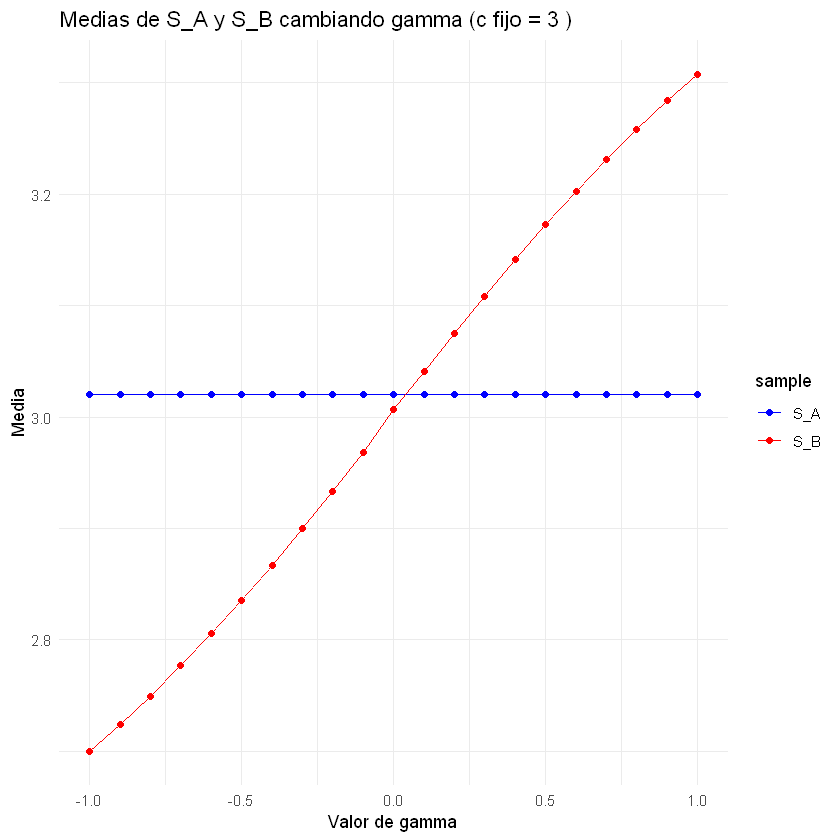

In [26]:
# Fijar un valor de c
c_value <- 3

# Definir los valores de gamma que queremos analizar
gamma_values <- seq(-1, 1, by = 0.10)

# Inicializar un dataframe para guardar los resultados
results_gamma <- data.frame(gamma_value = numeric(), sample = character(), media = numeric())
N = 100000

# Iterar sobre diferentes valores de gamma
for (gamma_value in gamma_values) {
  # Generar la población
  poblacion_NMAR <- generate_population_NMAR(N = N, size_a = 1000, size_muestra_B = 50000,
                                             gamma = gamma_value, c = c_value, seed_base = 1234)
  
  # Calcular la media observada en S_A
  mean_S_A <- mean(poblacion_NMAR$y_i[poblacion_NMAR$muestra_A == 1])
  
  # Calcular la media observada en S_B
  mean_S_B <- mean(poblacion_NMAR$y_i[poblacion_NMAR$muestra_B == 1])

  # Guardar los resultados
  results_gamma <- rbind(results_gamma, data.frame(gamma_value = gamma_value, sample = "S_A", media = mean_S_A))
  results_gamma <- rbind(results_gamma, data.frame(gamma_value = gamma_value, sample = "S_B", media = mean_S_B))
}

# Graficar las medias de S_A y S_B para diferentes valores de gamma
library(ggplot2)
ggplot(results_gamma, aes(x = gamma_value, y = media, color = sample)) +
  geom_line() +
  geom_point() +
  ggtitle(paste("Medias de S_A y S_B cambiando gamma (c fijo =", c_value, ")")) +
  xlab("Valor de gamma") +
  ylab("Media") +
  theme_minimal() +
  scale_color_manual(values = c("S_A" = "blue", "S_B" = "red"))

#### Unica iteración de prueba

In [27]:
# Simular la población
set.seed(42)
poblacion <- generate_population_NMAR(N = 100000, size_a = 1000, size_muestra_B = 50000, gamma = 0.25, c = 3)

# 1. Estimación de la media usando la muestra A
design_A <- svydesign(ids = ~1, data = subset(poblacion, muestra_A == 1), weights = ~1)
mean_S_A <- coef(svymean(~y_i, design_A))

# 2. Estimación de la media usando la muestra B
design_B <- svydesign(ids = ~1, data = subset(poblacion, muestra_B == 1), weights = ~1)
mean_S_B <- coef(svymean(~y_i, design_B))

# 3. PC usando x1_i y x2_i
result_PC_X1_X2 <- PC_Estimator(
  data = poblacion,
  y_A_col = "y_i",
  y_B_col = "y_i",
  ind_var_A = "muestra_A",
  ind_var_B = "muestra_B",
  aux_vars = c("x1_i", "x2_i"),
  N_total = nrow(poblacion),
  scenario = 1
)

# 4. PC usando e1_i y e2_i
result_PC_e1_e2 <- PC_Estimator(
  data = poblacion,
  y_A_col = "y_i",
  y_B_col = "y_i",
  ind_var_A = "muestra_A",
  ind_var_B = "muestra_B",
  aux_vars = c("e1_i", "e2_i"),
  N_total = nrow(poblacion),
  scenario = 1
)

# 5. RegDI usando x1_i
result_RegDI_X1 <- RegDI2(
  data = poblacion,
  y_A_col = "y_i",
  y_B_col = "y_i",
  ind_var_A = "muestra_A",
  ind_var_B = "muestra_B",
  aux_vars = c("x1_i"),
  N_total = nrow(poblacion)
)

# 6. RegDI usando e1_i
result_RegDI_e1 <- RegDI2(
  data = poblacion,
  y_A_col = "y_i",
  y_B_col = "y_i",
  ind_var_A = "muestra_A",
  ind_var_B = "muestra_B",
  aux_vars = c("e1_i"),
  N_total = nrow(poblacion)
)

# 7. PC usando x1_i y x2_i con un estimador doble robusto
result_PC_X1_X2_DR <- PC_Estimator(
  data = poblacion,
  y_A_col = "y_i",
  y_B_col = "y_i",
  ind_var_A = "muestra_A",
  ind_var_B = "muestra_B",
  aux_vars = c("x1_i", "x2_i"),
  N_total = nrow(poblacion),
  outcome_model = "y_i ~ x1_i + x2_i",
  model_type = "normal",
  scenario = 3
)

# 8. RegDI usando x1_i con un estimador doble robusto
result_RegDI_X1_DR <- RegDI2(
  data = poblacion,
  y_A_col = "y_i",
  y_B_col = "y_i",
  ind_var_A = "muestra_A",
  ind_var_B = "muestra_B",
  aux_vars = c("x1_i"),
  N_total = nrow(poblacion),
  outcome_model = "y_i ~ x1_i",
  correction = 3
)

# Imprimir resultados
cat("Media en muestra A:", mean_S_A, "\n")
cat("Media en muestra B:", mean_S_B, "\n")
cat("Estimador PC (x1_i, x2_i):", result_PC_X1_X2$estimator, "\n")
cat("Estimador PC (e1_i, e2_i):", result_PC_e1_e2$estimator, "\n")
cat("Estimador RegDI (x1_i):", result_RegDI_X1$mean_RegDI, "\n")
cat("Estimador RegDI (e1_i):", result_RegDI_e1$mean_RegDI, "\n")
cat("Estimador PC (Doble Robusto, x1_i, x2_i):", result_PC_X1_X2_DR$estimator_DR1, "\n")
cat("Estimador RegDI (Doble Robusto, x1_i):", result_RegDI_X1_DR$mean_RegDI, "\n")


Media en muestra A: 3.019955 
Media en muestra B: 3.091866 
Estimador PC (x1_i, x2_i): 3.06419 
Estimador PC (e1_i, e2_i): 3.08589 
Estimador RegDI (x1_i): 3.025545 
Estimador RegDI (e1_i): 3.025545 
Estimador PC (Doble Robusto, x1_i, x2_i): 3.06419 
Estimador RegDI (Doble Robusto, x1_i): 3.025014 


#### Simulación paralelizada

In [ ]:
# Definir el número de simulaciones por valor de gamma
n_sim <- 100

# Definir el vector de valores de gamma
gamma_values <- seq(0, 1, by = 0.1)

# Crear una lista para almacenar los resultados de todas las simulaciones
results_list <- list()

# Definir la función principal que se ejecutará en cada simulación
run_simulation <- function(gamma_value, sim_num) {
    
  # Generar la población
  poblacion <- generate_population_NMAR(N = 100000, size_a = 1000, size_muestra_B = 50000, gamma = gamma_value, c = 3, seed_base = sim_num)

  # 1. Estimación de la media usando la muestra A
  design_A <- svydesign(ids = ~1, data = subset(poblacion, muestra_A == 1), weights = ~1)
  mean_S_A <- coef(svymean(~y_i, design_A))

  # 2. Estimación de la media usando la muestra B
  design_B <- svydesign(ids = ~1, data = subset(poblacion, muestra_B == 1), weights = ~1)
  mean_S_B <- coef(svymean(~y_i, design_B))

  # 3. PC usando x1_i y x2_i
  result_PC_X1_X2 <- PC_Estimator(
    data = poblacion,
    y_A_col = "y_i",
    y_B_col = "y_i",
    ind_var_A = "muestra_A",
    ind_var_B = "muestra_B",
    aux_vars = c("x1_i", "x2_i"),
    N_total = nrow(poblacion),
    scenario = 1
  )

  # 4. PC usando e1_i y e2_i
  result_PC_e1_e2 <- PC_Estimator(
    data = poblacion,
    y_A_col = "y_i",
    y_B_col = "y_i",
    ind_var_A = "muestra_A",
    ind_var_B = "muestra_B",
    aux_vars = c("e1_i", "e2_i"),
    N_total = nrow(poblacion),
    scenario = 1
  )

  # 5. RegDI usando x1_i
  result_RegDI_X1 <- RegDI2(
    data = poblacion,
    y_A_col = "y_i",
    y_B_col = "y_i",
    ind_var_A = "muestra_A",
    ind_var_B = "muestra_B",
    aux_vars = c("x1_i"),
    N_total = nrow(poblacion)
  )

  # 6. RegDI usando e1_i
  result_RegDI_e1 <- RegDI2(
    data = poblacion,
    y_A_col = "y_i",
    y_B_col = "y_i",
    ind_var_A = "muestra_A",
    ind_var_B = "muestra_B",
    aux_vars = c("e1_i"),
    N_total = nrow(poblacion)
  )

  # 7. PC usando x1_i y x2_i con un estimador doble robusto
  result_PC_X1_X2_DR <- PC_Estimator(
    data = poblacion,
    y_A_col = "y_i",
    y_B_col = "y_i",
    ind_var_A = "muestra_A",
    ind_var_B = "muestra_B",
    aux_vars = c("x1_i", "x2_i"),
    N_total = nrow(poblacion),
    outcome_model = "y_i ~ x1_i + x2_i",
    model_type = "normal",
    scenario = 3,
    eval_model_performance = TRUE
  )

  # 8. RegDI usando x1_i con un estimador doble robusto
  result_RegDI_X1_DR <- RegDI2(
    data = poblacion,
    y_A_col = "y_i",
    y_B_col = "y_i",
    ind_var_A = "muestra_A",
    ind_var_B = "muestra_B",
    aux_vars = c("x1_i"),
    N_total = nrow(poblacion),
    outcome_model = "y_i ~ x1_i",
    correction = 3
  )

  # 9. RegDI usando x1_i con un estimador doble robusto
    result_PC_X_i_DR <- PC_Estimator(
        data = poblacion,
        y_A_col = "y_i",
        y_B_col = "y_i",
        ind_var_A = "muestra_A",
        ind_var_B = "muestra_B",
        aux_vars = c("x1_i", "x2_i"),
        N_total = nrow(poblacion),
        outcome_model = "y_i ~ x_i ",
        model_type = "normal",
        scenario = 3,
        eval_model_performance = TRUE
      )
    
  # Almacenar los resultados en un data.frame para esta simulación
  result_df <- data.frame(
    Simulacion = sim_num,
    Gamma = gamma_value,
    Media_S_A = mean_S_A,
    Media_S_B = mean_S_B,
    PC_X1_X2 = result_PC_X1_X2$estimator,
    PC_e1_e2 = result_PC_e1_e2$estimator,
    RegDI_X1 = result_RegDI_X1$mean_RegDI,
    RegDI_e1 = result_RegDI_e1$mean_RegDI,
    PC_X1_X2_DR = result_PC_X1_X2_DR$estimator_DR1,
    RegDI_X1_DR = result_RegDI_X1_DR$mean_RegDI
  )

  return(result_df)
}

# Usar paralelización para ejecutar las simulaciones de manera eficiente
cl <- makeCluster(detectCores() - 1)  # Detectar el número de núcleos y dejar uno libre
clusterEvalQ(cl, library(survey))  # Cargar librería survey en cada nodo del cluster
clusterExport(cl, c("generate_population_NMAR", "PC_Estimator", "RegDI2", "run_simulation"))  # Exportar funciones necesarias

# Iterar sobre los valores de gamma y ejecutar 100 simulaciones por valor
for (gamma_value in gamma_values) {
  # Exportar la variable `gamma_value` para cada iteración
  clusterExport(cl, "gamma_value")
  
  # Ejecutar simulaciones en paralelo para el valor de gamma actual
  sim_results <- parLapply(cl, 1:n_sim, function(sim_num) {
    run_simulation(gamma_value, sim_num)
  })
  
  # Convertir los resultados de la lista a un data.frame
  sim_results_df <- do.call(rbind, sim_results)
  
  # Almacenar los resultados en la lista general
  results_list[[as.character(gamma_value)]] <- sim_results_df
}

# Detener el cluster de paralelización
stopCluster(cl)

# Unir todos los resultados en un único data.frame
final_results <- do.call(rbind, results_list)

# Exportar los resultados a un archivo CSV
write.csv(final_results, "Resultados_simulacion_NMAR.csv", row.names = FALSE)

# Imprimir un mensaje indicando que la simulación ha finalizado
cat("Simulación completada. Los resultados se han guardado en 'Resultados_simulacion_NMAR.csv'.\n")


[[1]]
 [1] "survey"    "survival"  "Matrix"    "grid"      "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"     

[[2]]
 [1] "survey"    "survival"  "Matrix"    "grid"      "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"     

[[3]]
 [1] "survey"    "survival"  "Matrix"    "grid"      "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"     

[[4]]
 [1] "survey"    "survival"  "Matrix"    "grid"      "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"     

[[5]]
 [1] "survey"    "survival"  "Matrix"    "grid"      "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"     

[[6]]
 [1] "survey"    "survival"  "Matrix"    "grid"      "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"     

[[7]]
 [1] "survey"    "survival"  "Matrix"    "grid"      "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"

In [2]:
final_results <- read.csv("Resultados_simulacion_NMAR.csv")

In [22]:
# Calcular el promedio de sesgo para cada valor de Gamma
tabla_sesgo <- final_results %>%
  group_by(Gamma) %>%
  summarise(
    Promedio_Bias_S_B = round(mean(Bias_S_B, na.rm = TRUE),3),
    Promedio_Bias_PC_X1_X2 = round(mean(Bias_PC_X1_X2, na.rm = TRUE),3),
    Promedio_Bias_RegDI_X1 = round(mean(Bias_RegDI_X1, na.rm = TRUE),3),
    Promedio_Bias_RegDI_X1_DR = round(mean(Bias_PC_X1_X2_DR, na.rm = TRUE),3),
  )

# Ver la tabla
tabla_sesgo


Gamma,Promedio_Bias_S_B,Promedio_Bias_PC_X1_X2,Promedio_Bias_RegDI_X1,Promedio_Bias_RegDI_X1_DR
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.0,0.007,0.006,0.011,0.006
0.1,0.041,0.031,0.005,0.031
0.2,0.075,0.052,0.011,0.052
0.3,0.109,0.077,0.032,0.077
0.4,0.141,0.100,0.013,0.100
0.5,0.173,0.123,0.024,0.123
0.6,0.203,0.145,0.019,0.145
0.7,0.231,0.165,0.008,0.165
0.8,0.258,0.180,-0.013,0.180


Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


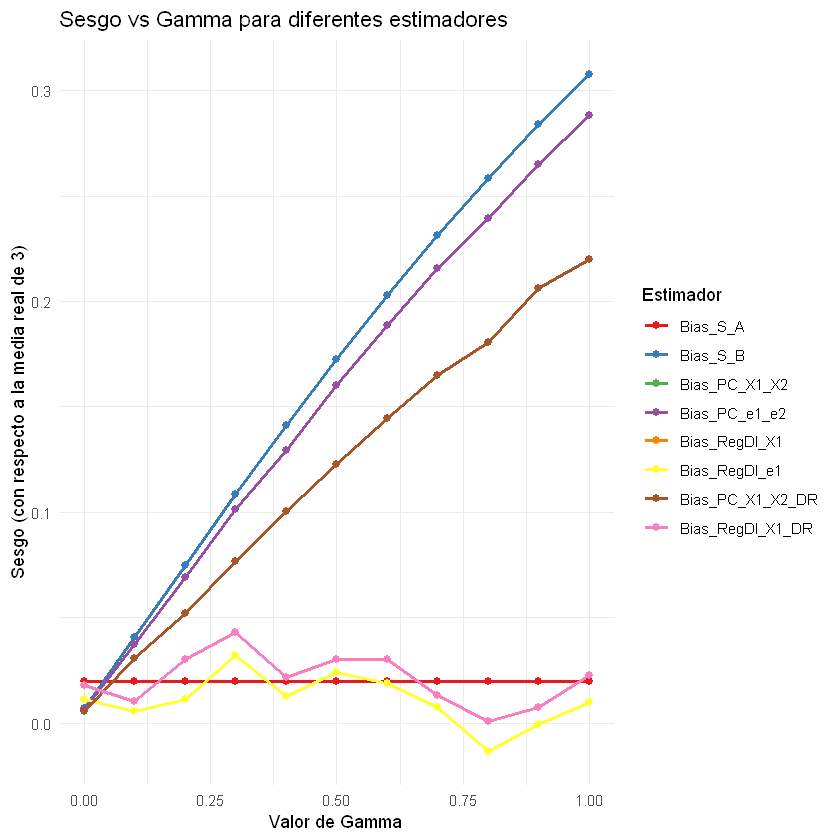

In [3]:
# Paso 1: Calcular el sesgo
final_results$Bias_S_A <- final_results$Media_S_A - 3
final_results$Bias_S_B <- final_results$Media_S_B - 3
final_results$Bias_PC_X1_X2 <- final_results$PC_X1_X2 - 3
final_results$Bias_PC_e1_e2 <- final_results$PC_e1_e2 - 3
final_results$Bias_RegDI_X1 <- final_results$RegDI_X1 - 3
final_results$Bias_RegDI_e1 <- final_results$RegDI_e1 - 3
final_results$Bias_PC_X1_X2_DR <- final_results$PC_X1_X2_DR - 3
final_results$Bias_RegDI_X1_DR <- final_results$RegDI_X1_DR - 3

# Paso 2: Transformar el dataframe en formato largo para ggplot
final_results_long <- melt(final_results, id.vars = c("Simulacion", "Gamma"), 
                           measure.vars = c("Bias_S_A", "Bias_S_B", "Bias_PC_X1_X2", "Bias_PC_e1_e2", 
                                            "Bias_RegDI_X1", "Bias_RegDI_e1", "Bias_PC_X1_X2_DR", 
                                            "Bias_RegDI_X1_DR"),
                           variable.name = "Estimador", value.name = "Sesgo")

# Paso 3: Generar el gráfico de Sesgo vs Gamma para todos los estimadores
ggplot(final_results_long, aes(x = Gamma, y = Sesgo, color = Estimador)) +
  geom_line(stat = "summary", fun = mean, size = 1) +  # Mostrar la media del sesgo
  geom_point(stat = "summary", fun = mean, size = 2) +  # Añadir puntos para los valores promedio
  labs(title = "Sesgo vs Gamma para diferentes estimadores",
       x = "Valor de Gamma",
       y = "Sesgo (con respecto a la media real de 3)") +
  theme_minimal() +
  theme(legend.position = "right") +
  scale_color_brewer(palette = "Set1")  # Paleta de colores


In [14]:
# Paso 1: Calcular el sesgo
final_results$Bias_S_A <- final_results$Media_S_A - 3
final_results$Bias_S_B <- final_results$Media_S_B - 3
final_results$Bias_PC_X1_X2 <- final_results$PC_X1_X2 - 3
final_results$Bias_PC_e1_e2 <- final_results$PC_e1_e2 - 3
final_results$Bias_RegDI_X1 <- final_results$RegDI_X1 - 3
final_results$Bias_RegDI_e1 <- final_results$RegDI_e1 - 3
final_results$Bias_PC_X1_X2_DR <- final_results$PC_X1_X2_DR - 3
final_results$Bias_RegDI_X1_DR <- final_results$RegDI_X1_DR - 3

# Paso 2: Transformar el dataframe en formato largo para ggplot
final_results_long <- melt(final_results, id.vars = c("Simulacion", "Gamma"), 
                           measure.vars = c("Bias_S_B", "Bias_PC_X1_X2", "Bias_PC_e1_e2", 
                                            "Bias_RegDI_X1", "Bias_PC_X1_X2_DR"),
                           variable.name = "Estimador", value.name = "Sesgo")

# Crear el gráfico con el símbolo griego γ en el eje x y sin la leyenda de tipo de línea
sesgo_plot <- ggplot(final_results_long, aes(x = Gamma, y = Sesgo, color = Estimador, linetype = Estimador)) +
  geom_line(stat = "summary", fun = mean, size = 1) +  # Mostrar la media del sesgo
  geom_point(stat = "summary", fun = mean, size = 2) +  # Añadir puntos para los valores promedio
  labs(title = "Sesgo vs γ para diferentes estimadores",
       x = expression(γ),  # Usar símbolo griego γ
       y = "Sesgo (con respecto a la media real de 3)") +
  theme_minimal() +
  theme(legend.position = "right") +
  scale_color_manual(values = c("Bias_S_B" = "blue", "Bias_RegDI_X1" = "green", 
                                "Bias_PC_X1_X2" = "purple", "Bias_PC_e1_e2" = "orange", 
                                "Bias_PC_X1_X2_DR" = "brown"),
                     labels = c("Bias_S_B" = "Media B",
                                "Bias_RegDI_X1" = "RegDI",
                                "Bias_PC_X1_X2" = expression(PC[("X"[1] * "," * "X"[2])]),
                                "Bias_PC_e1_e2" = expression(PC[("Ξ"[1] * "," * "Ξ"[2])]),
                                "Bias_PC_X1_X2_DR" = "PC[DR1]")) +  # Cambiar nombres en la leyenda
  scale_linetype_manual(values = c("Bias_S_B" = "solid", "Bias_RegDI_X1" = "solid",
                                   "Bias_PC_X1_X2" = "dashed", "Bias_PC_e1_e2" = "solid", 
                                   "Bias_PC_X1_X2_DR" = "dotted"),
                        guide = "none") +  # Eliminar la leyenda de tipo de línea
  geom_hline(yintercept = 0, color = "red", linetype = "dashed", size = 1)  # Línea roja en la media

# Guardar el gráfico en formato PNG con alta resolución
ggsave("sesgo_vs_gamma.png", plot = sesgo_plot, width = 10, height = 6, dpi = 300)




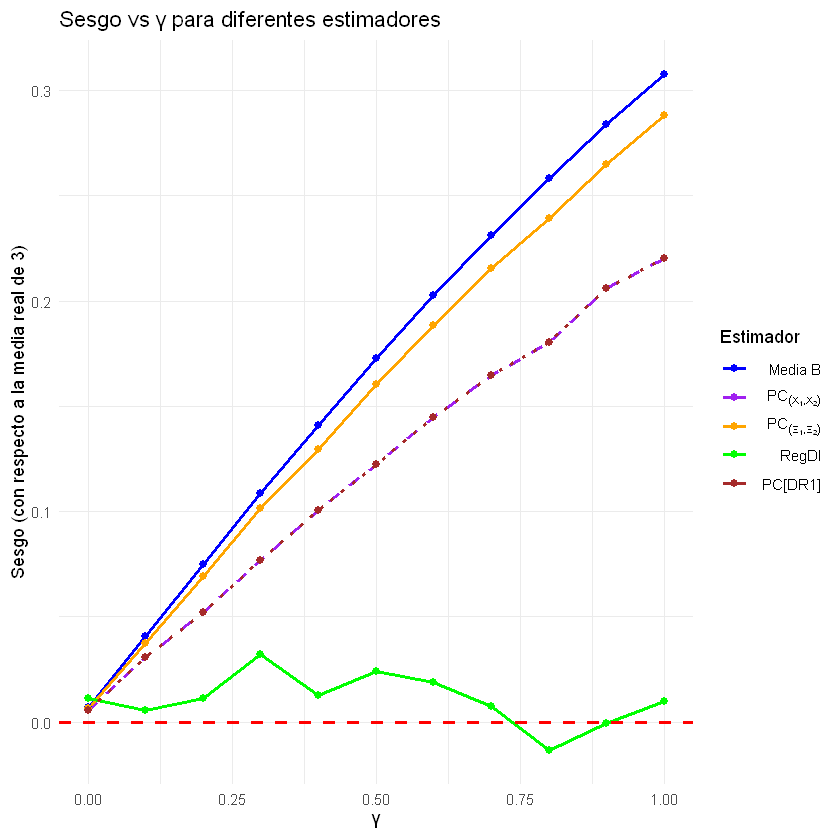

In [15]:
print(sesgo_plot)

### Nueva simulación. Caso: Variando la dificultad de predicción de yi

In [ ]:
source('PC.R')
source('RegDI2.R')

#### Generación de la población

In [ ]:
# Función para generar población bajo NMAR con múltiples variables objetivo y_i con diferentes SD en eta_i
generate_population_NMAR_v2 <- function(N = 100000, size_a = 1000, size_muestra_B = 50000,
                                        gamma = 0.25, c = 3, seed_base = 1234, sd_vector = c(0.5, 1, 2), Fixed = TRUE) {
  set.seed(seed_base)  # Asegurar reproducibilidad
  x_i <- rnorm(N, mean = 2, sd = 1)
  
  # Crear una lista para almacenar múltiples variables y_i con diferentes desviaciones estándar en eta_i
  y_list <- list()
  
  # Generar múltiples versiones de y_i con diferentes SD basadas en sd_vector que reemplazan a eta_i
  for (sd_value in sd_vector) {
    eta_i <- rnorm(N, mean = 0, sd = sd_value)  # Generar eta_i con la SD del vector
    y_i <- 3 + 0.7 * (x_i - 2) + eta_i  # Generar y_i con la eta_i ajustada por el sd_vector
    y_list[[paste0("y_i_sd_", sd_value)]] <- y_i  # Guardar con el nombre reflejando el valor de SD
  }

  # Crear las otras variables auxiliares como en la versión original
  rho <- 0.5
  v_i <- rnorm(N, mean = 0, sd = 1)
  e_i <- rho * x_i + sqrt(1 - rho^2) * v_i
  e1_i <- ifelse(e_i <= 1, 1, 0)
  e2_i <- ifelse(e_i > 1, 1, 0)
  
  x1_i <- ifelse(x_i <= 2, 1, 0)
  x2_i <- ifelse(x_i > 2, 1, 0)
  
  # Crear el dataframe de la población con las variables originales
  poblacion <- data.frame(
    id = 1:N,
    x_i = x_i,
    e_i = e_i,
    e1_i = e1_i,
    e2_i = e2_i,
    x1_i = x1_i,
    x2_i = x2_i
  )
  
  # Agregar las diferentes versiones de y_i al dataframe
  poblacion <- cbind(poblacion, do.call(cbind, y_list))
  
  # Generar las muestras A y B como en la versión original
  set.seed(seed_base + 1000)
  indices_A <- sample(1:N, size = size_a, replace = FALSE)
  poblacion$muestra_A <- 0
  poblacion$muestra_A[indices_A] <- 1
  
  # Usar la primera versión de y_i para calcular las probabilidades de selección de la muestra B
  prob_selection <- 1 / (1 + exp(-gamma * (poblacion[[paste0("y_i_sd_", sd_vector[1])]] - c)))

  set.seed(seed_base + 2000)
  if (Fixed) {
    prob_selection_normalized <- prob_selection / max(prob_selection)
    indices_B <- sample(1:N, size = size_muestra_B, replace = FALSE, prob = prob_selection_normalized)
  } else {
    indices_B <- which(runif(N) < prob_selection)
  }
  
  poblacion$muestra_B <- 0
  poblacion$muestra_B[indices_B] <- 1
  
  return(poblacion)
}

# Ejemplo de uso
set.seed(42)
poblacion_v2 <- generate_population_NMAR_v2(N = 100000, size_a = 1000, size_muestra_B = 50000, gamma = 0.25, c = 3, sd_vector = seq(0, 0.5, by = 0.125))


#### Una sola iteración de la función

In [ ]:
calcular_sesgo_R2 <- function(poblacion, sd_vector) {
  resultados <- data.frame()  # Para almacenar los resultados

  for (sd_value in sd_vector) {
    y_col_name <- paste0("y_i_sd_", sd_value)  # Nombre de la columna de la respuesta
    
    # 1. PC Estimador Doble Robusto con auxiliares x_i
    result_PC_xi_DR <- PC_Estimator(
      data = poblacion,
      y_A_col = y_col_name,
      y_B_col = y_col_name,
      ind_var_A = "muestra_A",
      ind_var_B = "muestra_B",
      aux_vars = c("x1_i", "x2_i"),
      N_total = nrow(poblacion),
      outcome_model = paste(y_col_name, "~ x1_i + x2_i"),
      model_type = "normal",
      scenario = 3,
      eval_model_performance = TRUE
    )

    # Calcular el sesgo
    sesgo_PC_xi_DR <- result_PC_xi_DR$estimator_DR1 - 3
    
    # 2. PC Estimador Doble Robusto con auxiliares e_i
    result_PC_ei_DR <- PC_Estimator(
      data = poblacion,
      y_A_col = y_col_name,
      y_B_col = y_col_name,
      ind_var_A = "muestra_A",
      ind_var_B = "muestra_B",
      aux_vars = c("e1_i", "e2_i"),
      N_total = nrow(poblacion),
      outcome_model = paste(y_col_name, "~ e1_i + e2_i"),
      model_type = "normal",
      scenario = 3,
      eval_model_performance = TRUE
    )
    
    # Calcular el sesgo
    sesgo_PC_ei_DR <- result_PC_ei_DR$estimator_DR1 - 3
    
    # 3. RegDI Estimador con auxiliares x_i
    result_RegDI_xi <- RegDI2(
      data = poblacion,
      y_A_col = y_col_name,
      y_B_col = y_col_name,
      ind_var_A = "muestra_A",
      ind_var_B = "muestra_B",
      aux_vars = c("x1_i"),
      N_total = nrow(poblacion),
      correction = 0
    )
    
    # Calcular el sesgo
    sesgo_RegDI_xi <- result_RegDI_xi$mean_RegDI - 3
    
    # 4. RegDI Estimador con auxiliares e_i
    result_RegDI_ei <- RegDI2(
      data = poblacion,
      y_A_col = y_col_name,
      y_B_col = y_col_name,
      ind_var_A = "muestra_A",
      ind_var_B = "muestra_B",
      aux_vars = c("e1_i"),
      N_total = nrow(poblacion),
      correction = 0
    )
    
    # Calcular el sesgo
    sesgo_RegDI_ei <- result_RegDI_ei$mean_RegDI - 3
    
    # Crear un dataframe temporal para los resultados
    resultado_temp <- data.frame(
      y_col_name = y_col_name,
      sesgo_PC_xi_DR = sesgo_PC_xi_DR,
      sesgo_PC_ei_DR = sesgo_PC_ei_DR,
      sesgo_RegDI_xi = sesgo_RegDI_xi,
      sesgo_RegDI_ei = sesgo_RegDI_ei
    )
    
    # Incluir R2 solo si está disponible
    if (!is.null(result_PC_xi_DR$R2)) {
      resultado_temp$R2_PC_xi_DR <- result_PC_xi_DR$R2
    }
    
    if (!is.null(result_PC_ei_DR$R2)) {
      resultado_temp$R2_PC_ei_DR <- result_PC_ei_DR$R2
    }
    
    # Agregar los resultados al dataframe final
    resultados <- rbind(resultados, resultado_temp)
  }
  
  return(resultados)
}

# Ejecutar la función sobre la población generada
resultados_sesgo_R2 <- calcular_sesgo_R2(poblacion_v2, seq(0, 0.5, by = 0.125))

# Mostrar los resultados finales
print(resultados_sesgo_R2)


#### Simulación completa

In [ ]:
library(survey)
library(dplyr)
library(parallel)

# Definir el número de simulaciones por valor de gamma
n_sim <- 100

# Definir el vector de valores de gamma
gamma_values <- seq(0, 1, by = 0.1)

# Definir el vector de desviaciones estándar para y_i
sd_vector <- seq(0, 0.5, by = 0.125)

# Crear una lista para almacenar los resultados de todas las simulaciones
results_list <- list()

# Función para ejecutar una simulación por valor de gamma
run_simulation <- function(gamma_value, sim_num) {
  
  # Generar la población con los diferentes valores de gamma y sd_vector
  poblacion <- generate_population_NMAR_v2(N = 100000, size_a = 1000, size_muestra_B = 50000, gamma = gamma_value, c = 3, seed_base = sim_num, sd_vector = sd_vector)
  
  result_row <- data.frame(Simulacion = sim_num, Gamma = gamma_value)  # Inicializar una fila de resultados
  
  # Iterar sobre cada desviación estándar de la variable objetivo y_i
  for (sd_value in sd_vector) {
    y_col_name <- paste0("y_i_sd_", sd_value)  # Nombre de la columna de la respuesta
    
    # 1. PC Estimador Doble Robusto con variables auxiliares x_i
    result_PC_xi_DR <- PC_Estimator(
      data = poblacion,
      y_A_col = y_col_name,
      y_B_col = y_col_name,
      ind_var_A = "muestra_A",
      ind_var_B = "muestra_B",
      aux_vars = c("x1_i", "x2_i"),
      N_total = nrow(poblacion),
      outcome_model = paste(y_col_name, "~ x1_i + x2_i"),
      model_type = "normal",
      scenario = 3,
      eval_model_performance = TRUE
    )
    
    # 2. PC Estimador Doble Robusto con variables auxiliares e_i
    result_PC_ei_DR <- PC_Estimator(
      data = poblacion,
      y_A_col = y_col_name,
      y_B_col = y_col_name,
      ind_var_A = "muestra_A",
      ind_var_B = "muestra_B",
      aux_vars = c("e1_i", "e2_i"),
      N_total = nrow(poblacion),
      outcome_model = paste(y_col_name, "~ e1_i + e2_i"),
      model_type = "normal",
      scenario = 3,
      eval_model_performance = TRUE
    )
    
    # 3. RegDI sin auxiliares
    result_RegDI_no_aux <- RegDI2(
      data = poblacion,
      y_A_col = y_col_name,
      y_B_col = y_col_name,
      ind_var_A = "muestra_A",
      ind_var_B = "muestra_B",
      N_total = nrow(poblacion),
      correction = 0
    )
    
    # 4. RegDI con auxiliares x_i
    result_RegDI_xi <- RegDI2(
      data = poblacion,
      y_A_col = y_col_name,
      y_B_col = y_col_name,
      ind_var_A = "muestra_A",
      ind_var_B = "muestra_B",
      aux_vars = c("x1_i"),
      N_total = nrow(poblacion),
      correction = 1
    )
    
    # 5. RegDI con auxiliares e_i
    result_RegDI_ei <- RegDI2(
      data = poblacion,
      y_A_col = y_col_name,
      y_B_col = y_col_name,
      ind_var_A = "muestra_A",
      ind_var_B = "muestra_B",
      aux_vars = c("e1_i"),
      N_total = nrow(poblacion),
      correction = 1
    )
    
    # Agregar los resultados de cada estimador y desviación estándar a la fila de resultados
    result_row[paste0("mean_PC_xi_DR_", y_col_name)] <- result_PC_xi_DR$estimator_DR1
    result_row[paste0("mean_PC_ei_DR_", y_col_name)] <- result_PC_ei_DR$estimator_DR1
    result_row[paste0("mean_RegDI_no_aux_", y_col_name)] <- result_RegDI_no_aux$mean_RegDI
    result_row[paste0("mean_RegDI_xi_", y_col_name)] <- result_RegDI_xi$mean_RegDI
    result_row[paste0("mean_RegDI_ei_", y_col_name)] <- result_RegDI_ei$mean_RegDI
    
    # Incluir R2 si está disponible
    if (!is.null(result_PC_xi_DR$R2)) {
      result_row[paste0("R2_PC_xi_DR_", y_col_name)] <- result_PC_xi_DR$R2
    }
    if (!is.null(result_PC_ei_DR$R2)) {
      result_row[paste0("R2_PC_ei_DR_", y_col_name)] <- result_PC_ei_DR$R2
    }
  }
  
  return(result_row)
}

# Usar paralelización para ejecutar las simulaciones de manera eficiente
cl <- makeCluster(detectCores() - 1)  # Detectar el número de núcleos y dejar uno libre
clusterEvalQ(cl, library(survey))  # Cargar librería survey en cada nodo del cluster
clusterExport(cl, c("generate_population_NMAR_v2", "PC_Estimator", "RegDI2", "run_simulation", "sd_vector"))  # Exportar funciones necesarias

# Iterar sobre los valores de gamma y ejecutar simulaciones por valor
for (gamma_value in gamma_values) {
  clusterExport(cl, "gamma_value")
  
  # Ejecutar simulaciones en paralelo para el valor de gamma actual
  sim_results <- parLapply(cl, 1:n_sim, function(sim_num) {
    run_simulation(gamma_value, sim_num)
  })
  
  # Convertir los resultados de la lista a un data.frame
  sim_results_df <- do.call(rbind, sim_results)
  
  # Almacenar los resultados en la lista general
  results_list[[as.character(gamma_value)]] <- sim_results_df
}

# Detener el cluster de paralelización
stopCluster(cl)

# Unir todos los resultados en un único data.frame
final_results <- do.call(rbind, results_list)

# Exportar los resultados a un archivo CSV
write.csv(final_results, "Resultados_simulacion_NMAR_v2.csv", row.names = FALSE)

# Imprimir un mensaje indicando que la simulación ha finalizado
cat("Simulación completada. Los resultados se han guardado en 'Resultados_simulacion_NMAR_v2.csv'.\n")


#### Resultados

In [9]:
final_results_2 <- read.csv("Resultados_simulacion_NMAR_v2.csv")

In [32]:
# Identificar las columnas de estimadores
estimators <- colnames(final_results_2) %>% 
  grep("mean_", ., value = TRUE)  # Opcional: filtrar ciertos estimadores

# Calcular el sesgo
final_results_2 <- final_results_2 %>%
  mutate(across(starts_with("mean_"), ~ . - 3, .names = "bias_{.col}"))

In [67]:
# Reestructurar para los sesgos
bias_data <- final_results_2 %>%
  select(Simulacion, Gamma, starts_with("bias_mean_")) %>%
  pivot_longer(
    cols = starts_with("bias_mean_"),
    names_to = "Estimator_Sd",
    values_to = "Bias"
  ) %>%
  separate(Estimator_Sd, into = c("Metric", "Estimator", "Sd"), sep = "_mean_|_sd_") %>%
  mutate(Sd = as.numeric(Sd))

# Calcular el sesgo promedio, su variabilidad, y el RMSE redondeando a 3 decimales
bias_summary <- bias_data %>%
  group_by(Gamma, Sd, Estimator) %>%
  summarize(
    Bias_Mean = round(mean(Bias, na.rm = TRUE), 3),
    Bias_SD = round(sd(Bias, na.rm = TRUE), 3),
    RMSE = round(sqrt((Bias_Mean)^2 + (Bias_SD)^2), 3),
    .groups = 'drop'
  )

# Reestructurar para los R2
r2_data <- final_results_2 %>%
  select(Simulacion, Gamma, starts_with("R2_")) %>%
  pivot_longer(
    cols = starts_with("R2_"),
    names_to = "Estimator_Sd",
    values_to = "R2"
  ) %>%
  separate(Estimator_Sd, into = c("Metric", "Estimator", "Sd"), sep = "R2_|_sd_") %>%
  mutate(Sd = as.numeric(Sd))

# Calcular R2 promedio y su variabilidad
r2_summary <- r2_data %>%
  group_by(Gamma, Sd, Estimator) %>%
  summarize(
    R2_Mean = round(mean(R2, na.rm = TRUE),3),
    R2_SD = round(sd(R2, na.rm = TRUE),3),
    .groups = 'drop'
  )

# Crear una lista para almacenar las tablas de cada estimador
tables_list <- list()

# Iterar por cada estimador
for (estimator in unique(bias_summary$Estimator)) {
  # Filtrar datos para el estimador actual
  estimator_data <- bias_summary %>%
    filter(Estimator == estimator)
  
  # Crear la tabla de sesgo (Bias Mean) con pivot_wider
  table <- estimator_data %>%
    select(Gamma, Sd, Bias_Mean) %>%
    pivot_wider(names_from = Sd, values_from = Bias_Mean)
  
  # Añadir a la lista de tablas
  tables_list[[estimator]] <- table
}

# Mostrar cada tabla
for (estimator in names(tables_list)) {
  print(paste("Tabla de Sesgo para el Estimador:", estimator))
  print(tables_list[[estimator]])
  cat("\n")
}


[1] "Tabla de Sesgo para el Estimador: PC_ei_DR_y_i"
# A tibble: 11 × 6
   Gamma   `0` `0.125` `0.25` `0.375` `0.5`
   <dbl> <dbl>   <dbl>  <dbl>   <dbl> <dbl>
 1   0   0       0      0       0     0    
 2   0.1 0.014   0.014  0.014   0.014 0.014
 3   0.2 0.028   0.028  0.028   0.028 0.028
 4   0.3 0.043   0.043  0.043   0.042 0.043
 5   0.4 0.056   0.056  0.056   0.056 0.056
 6   0.5 0.07    0.07   0.07    0.07  0.07 
 7   0.6 0.084   0.084  0.084   0.083 0.084
 8   0.7 0.097   0.097  0.097   0.097 0.097
 9   0.8 0.11    0.11   0.11    0.11  0.11 
10   0.9 0.122   0.123  0.123   0.122 0.123
11   1   0.135   0.135  0.135   0.134 0.135

[1] "Tabla de Sesgo para el Estimador: PC_xi_DR_y_i"
# A tibble: 11 × 6
   Gamma   `0` `0.125` `0.25` `0.375` `0.5`
   <dbl> <dbl>   <dbl>  <dbl>   <dbl> <dbl>
 1   0   0       0      0       0     0    
 2   0.1 0.006   0.006  0.006   0.006 0.006
 3   0.2 0.012   0.012  0.012   0.012 0.012
 4   0.3 0.018   0.018  0.018   0.018 0.018
 5   0.4 0.024   0.

In [79]:
# Convertir bias_data a un data frame de estructura apropiada para ANOVA
anova_data <- bias_data %>% 
  select(Gamma, Sd, Estimator, Bias)

# Realizar ANOVA de dos factores, incluyendo la interacción entre Gamma y Sd
anova_results <- aov(Bias ~ factor(Sd) * factor(Gamma) + Estimator, data = anova_data)

# Resumen del modelo ANOVA
summary(anova_results)


                            Df Sum Sq Mean Sq   F value Pr(>F)    
factor(Sd)                   4  0.001   0.000     0.624  0.645    
factor(Gamma)               10  4.124   0.412   877.421 <2e-16 ***
Estimator                    4 20.258   5.065 10776.257 <2e-16 ***
factor(Sd):factor(Gamma)    40  0.001   0.000     0.065  1.000    
Residuals                27441 12.896   0.000                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

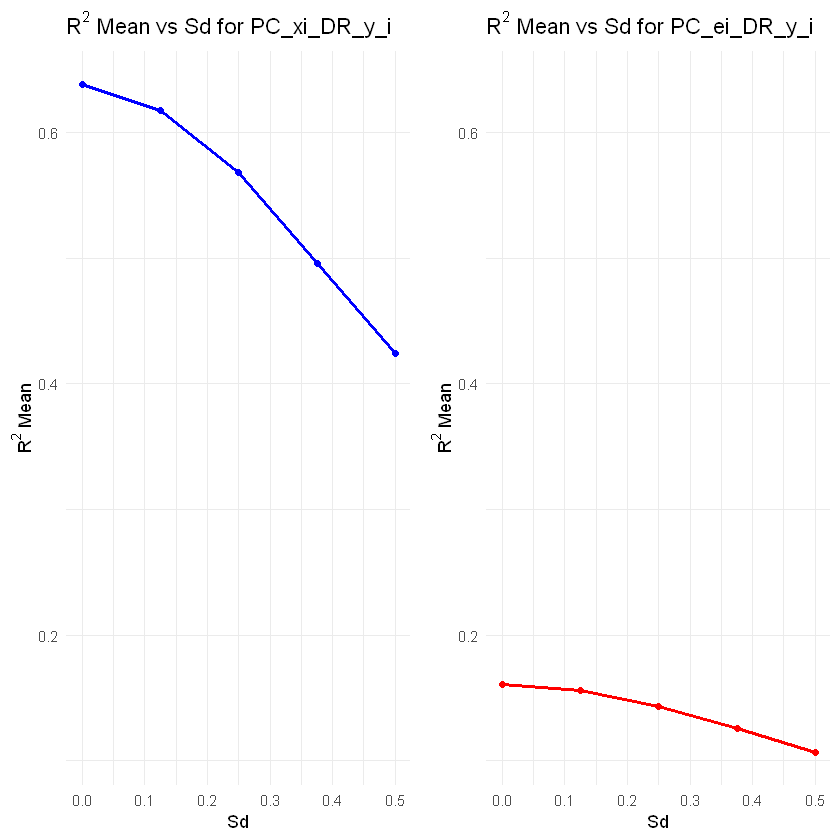

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


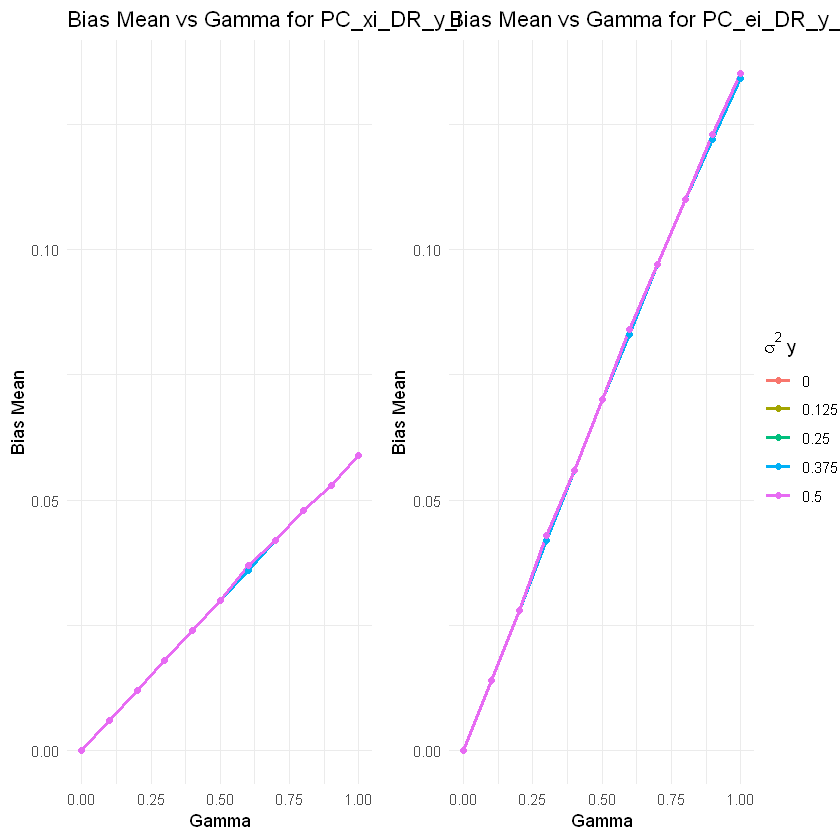

In [74]:
# Datos filtrados para cada estimador de interés
estimadores_bias <- bias_summary %>% filter(Estimator %in% c("PC_xi_DR_y_i", "PC_ei_DR_y_i"))
estimadores_r2 <- r2_summary %>% filter(Estimator %in% c("PC_xi_DR_y_i", "PC_ei_DR_y_i"))

# Graficos de Bias Mean vs Gamma para ambos estimadores
p1 <- ggplot(estimadores_bias %>% filter(Estimator == "PC_xi_DR_y_i"), aes(x = Gamma, y = Bias_Mean, color = factor(Sd))) +
  geom_line(size = 1) + geom_point() +
  labs(title = "Bias Mean vs Gamma for PC_xi_DR_y_i", x = "Gamma", y = "Bias Mean", color = expression(sigma^2 ~ y)) +
  scale_y_continuous(limits = c(min(estimadores_bias$Bias_Mean), max(estimadores_bias$Bias_Mean))) +
  scale_x_continuous(limits = c(min(estimadores_bias$Gamma), max(estimadores_bias$Gamma))) +
  theme_minimal()

p2 <- ggplot(estimadores_bias %>% filter(Estimator == "PC_ei_DR_y_i"), aes(x = Gamma, y = Bias_Mean, color = factor(Sd))) +
  geom_line(size = 1) + geom_point() +
  labs(title = "Bias Mean vs Gamma for PC_ei_DR_y_i", x = "Gamma", y = "Bias Mean", color = expression(sigma^2 ~ y)) +
  scale_y_continuous(limits = c(min(estimadores_bias$Bias_Mean), max(estimadores_bias$Bias_Mean))) +
  scale_x_continuous(limits = c(min(estimadores_bias$Gamma), max(estimadores_bias$Gamma))) +
  theme_minimal()

# Unir los gráficos de Bias Mean vs Gamma con una sola leyenda
legend <- get_legend(p1)
p1_no_legend <- p1 + theme(legend.position = "none")
p2_no_legend <- p2 + theme(legend.position = "none")
bias_gamma_grid <- plot_grid(p1_no_legend, p2_no_legend, legend, ncol = 3, rel_widths = c(1, 1, 0.2))

# Graficos de R2 Mean vs Sd para ambos estimadores
p3 <- ggplot(estimadores_r2 %>% filter(Estimator == "PC_xi_DR_y_i"), aes(x = Sd, y = R2_Mean)) +
  geom_line(size = 1, color = "blue") + geom_point(color = "blue") +
  labs(title = expression("R"^2~"Mean vs Sd for PC_xi_DR_y_i"), x = "Sd", y = expression("R"^2~"Mean")) +
  scale_y_continuous(limits = c(min(estimadores_r2$R2_Mean), max(estimadores_r2$R2_Mean))) +
  scale_x_continuous(limits = c(min(estimadores_r2$Sd), max(estimadores_r2$Sd))) +
  theme_minimal()

p4 <- ggplot(estimadores_r2 %>% filter(Estimator == "PC_ei_DR_y_i"), aes(x = Sd, y = R2_Mean)) +
  geom_line(size = 1, color = "red") + geom_point(color = "red") +
  labs(title = expression("R"^2~"Mean vs Sd for PC_ei_DR_y_i"), x = "Sd", y = expression("R"^2~"Mean")) +
  scale_y_continuous(limits = c(min(estimadores_r2$R2_Mean), max(estimadores_r2$R2_Mean))) +
  scale_x_continuous(limits = c(min(estimadores_r2$Sd), max(estimadores_r2$Sd))) +
  theme_minimal()

r2_sd_grid <- grid.arrange(p3, p4, ncol = 2)

# Mostrar los tres gráficos
print(bias_gamma_grid)
print(r2_sd_grid, vp=grid::viewport(width=unit(16, 'inch'), height=unit(8, 'inch')))


`geom_smooth()` using formula = 'y ~ x'
Warning message:
"Removed 165 rows containing non-finite values (`stat_smooth()`)."
Warning message:
"Removed 165 rows containing missing values (`geom_point()`)."


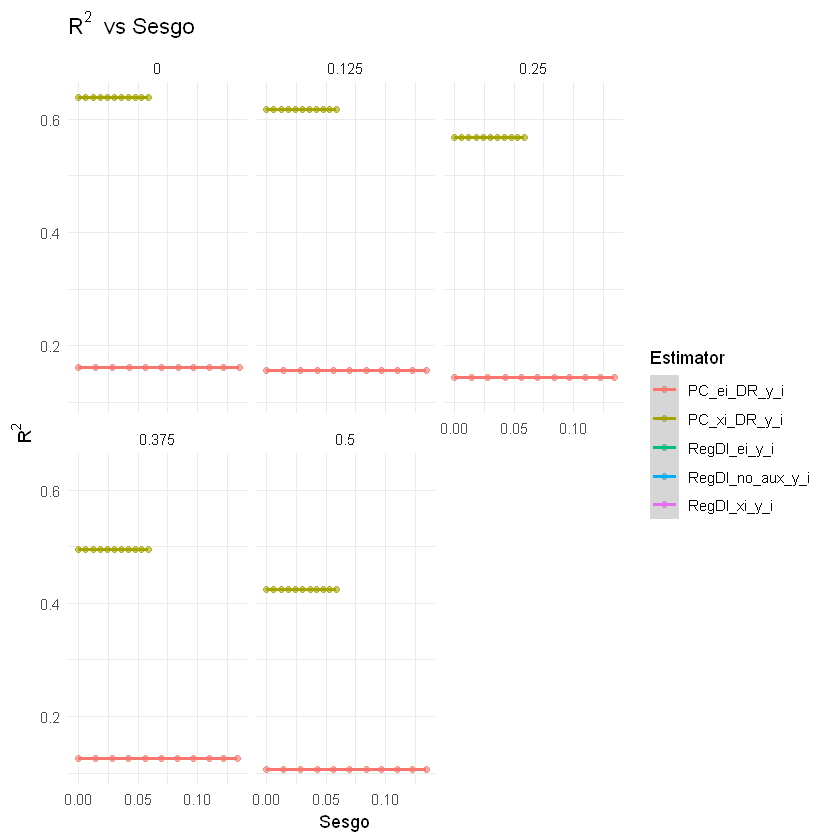

In [58]:
# Combinar bias y R2
combined_summary <- bias_summary %>%
  left_join(r2_summary, by = c("Gamma", "Sd", "Estimator"))

# Plot R2 vs Sesgo
ggplot(combined_summary, aes(x = Bias_Mean, y = R2_Mean, color = Estimator)) +
  geom_point(alpha = 0.6) +
  geom_smooth(method = "loess") +
  facet_wrap(~ Sd) +
  labs(title = expression(R^2 ~ " vs Sesgo"),
       x = "Sesgo",
       y = expression(R^2)) +
  theme_minimal()
